In [23]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [24]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read() #change if image captioning
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [25]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

#change if image captioning
# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [26]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [33]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        #self.rnn = nn.RNNCell(self.input_size, self.hidden_size) #change this to LSTM to GRU
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, 2)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = self.rnn(input,hidden)###### To be filled ######
        #print(input.shape)
        #print(hidden.shape)
        output,(h0,c0) = self.rnn(input,hidden)
        hidden = (h0,c0)
        #output =self.linear(hidden) ###### To be filled ######
        output = self.linear(output)
        #print(self.output.size)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return (torch.zeros(2, 1,self.hidden_size).to(device),torch.zeros(2, 1,self.hidden_size).to(device)) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): LSTM(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [28]:
output_list = []
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    #for t in range(seq_len):    # For each one in the input sequence.
   # print("target.shape")
    #print(target.shape)
    output, hidden = net(input, hidden)
    output = output.reshape(seq_len,-1)
    target = target.reshape(-1)
    output_list.append(output)
    #print("target.shape")
    #print(target.shape)
    #print("output.shape")
    #print(output.shape)
    
    loss += loss_func(output, target)

    loss.backward()             # Backward.  #comment if not update model
    opt.step()                  # Update the weights. #comment if not update model

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [29]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    #for t in range(len(init_seq) - 1):
    #output, hidden = net(init_input, hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input
    
    #print(output.shape)
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        
        output, hidden = net(input, hidden)
        
        # Get the current output and hidden state.
        #output_t = output[t]
        
        #output, hidden = net(input[t].reshape(, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char).to(device)

    return predicted_seq

#### Training Procedure

In [30]:
#when hidden_size is 512

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.0318281389772892
generated sequence: Wtte:oefffmAdhr t uhow ep
du  CeRe uvmeByeAdtv :i r dP nmfd yglffw kg ve Ttte iuyvnoapd fdByevtdnodrn

iter:199/15000 loss:0.027522752061486244
generated sequence: Wi!ih !t  tnscletyh ymuya  
ai ,  sg.cfouO tdcdmmttuiTCa'diry  n ebitmiis tst e
?ii
wemd mslmmtasgaKi

iter:299/15000 loss:0.027823809534311295
generated sequence: Wreyd PceGCCLaoen t'iaedoo krsa  dtse ihoidoa? fh,rne otnirot e
nad us hl'segoas O nts st se r hietgs

iter:399/15000 loss:0.026997774839401245
generated sequence: Wand aroo:rbh d;nra  altb mnee Ltbwt  rrkl g w s  dn  bt tyaeoc vlkrt ol ateoara aooUr rdha nv o oT r

iter:499/15000 loss:0.02676704339683056
generated sequence: Wcoete n 'l llorbd
seea'ied Ye'aVmltRi
e o r  ai' olgdWat,Mb
eg'euP
woc'a
ek tr gmoo hv
nrheleeobosu 

iter:599/15000 loss:0.026826348155736923
generated sequence: Woeat af l nW iA antlsehol slb ktovslgsseoeAel de,fo  harotteeaKdoaftritIodY  sr dc
yh t'vre B hfoY s

iter:699/15000 loss:

#### Training Loss Curve

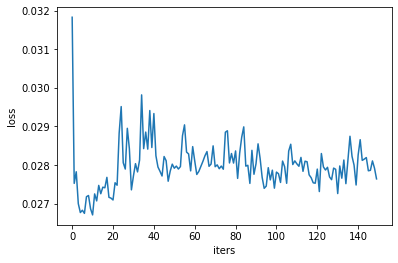

In [31]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [32]:
print(eval_step(net, predicted_len=600))

W hh etih h lelle tp.Silsoe

reIy   Pch.  h 
  ws ee ,ilwtpc rrsS  w ig  ghi 
 oea?itSfnm? ?wtqiev oi :d   pt Seson clp,hmhtit
b?Fnseeev ? eme?pidhh
tnissT
ett
   hsw ul?ns.en? tm Artepieg
hor taso vhd
lbtw hoikgte  o? iAsl s
t gSohotAuiesegsv
wt


 crpo  l  bt sh e mi  tbe pf
ssasiflhnintrlt?hns 
 ios
wbuenik: htoshh sorlhipohWi?,  w?? ah iwlEh
bo
sgeatoe sogioEreo?sgnse w Ft?h:pots upd u ceonls ?o
e isai?psno
hb? isme yes
 igieoahtdnrshs , twlge,t oiho stitmittu  AAluAthmdd gshheke
,mhhhtErw e     
pt hebwmei
  aiotwbe spmit ?  ,fho gcdwhrse tigc oNpd nepihs  htwnwhges
s,ssa e h yhrhpw w oohe


In [31]:
#I have two models
#retrain the same datasets on the new_train_method where update model is commented, compare the loss of model1 and model2, greater = bad 

In [34]:
#Adagrad as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adagrad(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.02668551541864872
generated sequence: W t  nh  i,owathsyec n
rh aesdd tada.aihsi Ihc,rsfdw 'w
u,tm  b
 gowJkmass Ca :Doite phh  rshIe o rlo

iter:199/15000 loss:0.025931162759661674
generated sequence: W!O q ninyr hee,e ~.

  Rehereeoa
reehfds rcrr,sTr
knvnuSesid 

 onvmeswuro iordon ssfs,rhTauTeoittWr

iter:299/15000 loss:0.02559470385313034
generated sequence: Woew ou :bctyg ghe Afhe. Fnaowleryo IamwnVre brc
s
f ur e , !h lree mleoesdr egme
d Ws   e Aeclr:oaah

iter:399/15000 loss:0.02468801662325859
generated sequence: Weise t moreTd ro muTlh. th t. ne! ch sumos cf v
huenr v u: so-th na
Nre
c,lw neayskd.tmediwe naIPs O

iter:499/15000 loss:0.023070240393280983
generated sequence: Wth
ih morsgtt siilt gfias  n Rw uwtet Aitat kh taayoni,nuifi thet ant Tns muts Aneetee,ichiye
hheg t

iter:599/15000 loss:0.021564578637480736
generated sequence: Wuere
thom gond
fiae
AuUT.r brrr.h  whit rrh; a
varde
h vomonige gon gesv tn?y lir
osnthoet
Oithireak

iter:699/15000 loss:

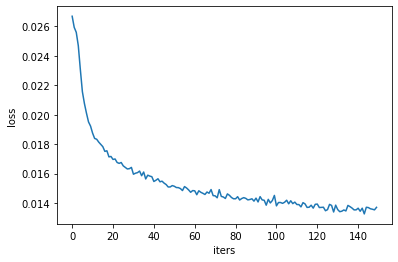

In [35]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [36]:
print(eval_step(net, predicted_len=600))

Who by mency.

TRUCENIZARREN:
Semmends? 'vrokt to barringemy, a onguding,
Year lenoth, what your heol, uponier and-spales.

ASTAOWO:
Not nime'd ele thee, would. he raght'd for I witaret or alpst inchous; the plood no lives oul mught of mine,
As farams fellmorle, beast,
And soo lidy forrise to, part of my entiniol, ade wend it inderle when, byh wele.
The hous
That to gase blood most if my flich offorestce lives, see-gene
The? Sothe vincous.

Furptixer:
Owwed to mises that you gived, glom
To ganst be couqles! Whene iteels resturired,
That will your anjototerene rade.

DUKE BINCAD:
I stand thy kaw


In [37]:
#AdamW as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.AdamW(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.014535120688378811
generated sequence: Worm and manfat,
And runjime you nrokn, with and nam, welp;
Nor hemy in for: get bing hamben mine we 

iter:199/15000 loss:0.014413412660360336
generated sequence: Whe hast her heres has lay, the mwond dathering that have his her a pleirs a nor Gry this hoir treser

iter:299/15000 loss:0.014353119768202305
generated sequence: Wit haves died bristaading notue, if I som is inseen,
Eb'm, fant to sires! have yothir.

BUCKI GoOn:


iter:399/15000 loss:0.014281903393566608
generated sequence: Whetentle they slaed thesenbed sides it bake of this
banuss we fiest hasger
A can hack them wnohes to

iter:499/15000 loss:0.01428589504212141
generated sequence: Wing to hone revid to dorer ofpes, heo!
Cones rigcue! to thy heveritnmen, for
kis provigaan tapcey:
I

iter:599/15000 loss:0.014035014435648918
generated sequence: Wall King the say, fornt fall reared for ol bear so:
I am have no be and your not a prodictrot paing'

iter:699/15000 los

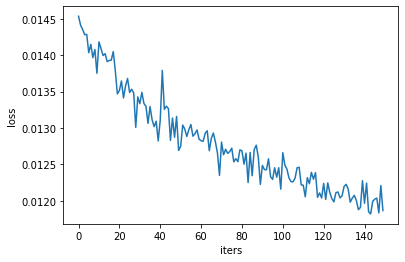

In [38]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [39]:
print(eval_step(net, predicted_len=600))

Wind your eyes of litger bockly,
No more the  wash. What you will not see his hands
citizence confly,
Thy infuraby by the nobles war cannot
Can discondight and Forries of tlaturd's
Agaven. Tell your gutsty,
He would newper for Clreals.

FLORIZEL:
Your moralf, I appel is away thave too, O fulling
Judies to acciditionshall be child to see,
And telce revertent, it as your cust this nir? Come,
The glakmind soler young thing'st have who doubt.
First thou? what cen, not hooman signience
Lord not twa, and them, fair kings,
And I do not bick as do his gods med in the bold,
Till spair outs Mitiemen?
3 K


In [40]:
#Adamax as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adamax(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.011840647086501122
generated sequence: What heard thine,
You wept hath impiders; with leignoness?
For this are not will make imeractingh own

iter:199/15000 loss:0.011666378937661648
generated sequence: Why hearts. King deaurs thyselfend
Farspects to bo not of her grace too
bernight nor 'calls tow, know

iter:299/15000 loss:0.011485263705253601
generated sequence: We lived never we granged;
And one grown which being my bloodion of your dught of him:
He were renemi

iter:399/15000 loss:0.01160952914506197
generated sequence: WAtWerding; and hadselp, I tremucrest
Sick advicer'd frown, if it worder'd upon a rlef,
And with Kela

iter:499/15000 loss:0.011457346379756927
generated sequence: Werm o is give joy;
His deakly? would yiel, that use such is is gentle
Rear; care confent to curlible

iter:599/15000 loss:0.01161819789558649
generated sequence: What'st foul walf aboply to sey not thousand me.
But I he's you takes O profute with the stine;
What 

iter:699/15000 loss

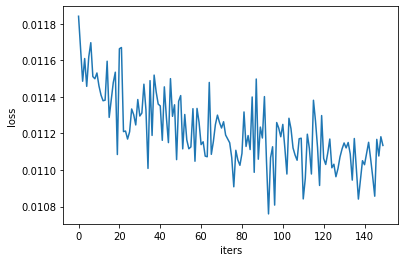

In [41]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [42]:
print(eval_step(net, predicted_len=600))

What re folly-no
Genour'st afterea, on thy breather's filly is. How doing; and many of when hither,
That who and then and a hope or ege,
Whom doth so. Pivies, so the dought may pabholicg.

Messenger:
Does as fortunage' step I go that has not hates here
Clarence nor be on my friends of this stite,
And time an ancient his pleased
would be servents and stands; who proters and in
the horse; them instrumentsian shall not lightror
Most our nir; for it is sendsh of seem.

Second King:
You say, good my blood, Bolingbroved bideld this:
Still wisther may mind Bableared his way to you in him!
How is my li


In [43]:
#RMSprop as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.RMSprop(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.04217882081866264
generated sequence: WereoedN  ewosforehsohE'o nfiuh eI;pfreeuIfsbooogA eSs
u fno  teogeitoe  hw eet  au  fteewhe'm srlsB'

iter:199/15000 loss:0.027592327445745468
generated sequence: WysaooM endt snuodhodoeeomy,e hueabsi,e ln  uosRuhon hh,omoh ie to
v obomnha tli efo:veoa esh n  evC 

iter:299/15000 loss:0.027742143720388412
generated sequence: W:y Iu ochaoOehs
tnA a.caoWnygtysnphneoolu  
Lr phTe
hudwWgsa  aniInssspegnamn'mpd oo.b'm hearha wato

iter:399/15000 loss:0.027992315590381622
generated sequence: W,tItar AAattentCdtict   hh   sC brtl wtftes ,t soeef v
   T  yhh:nC e st hhh tseia  t o:O e d sbci n

iter:499/15000 loss:0.027904914692044258
generated sequence: Wt d 'T hUoho
essMnbor nbiis tSetpsosiT oshhsni abAT, hauu  sos srs tne    tuTuseTtL ihmc   schhs tAr

iter:599/15000 loss:0.028216678649187088
generated sequence: Weg Utby  oa  sIldo:  g  retUda wdw, , eaa m atIesae h' awd  d;ra:y wo iae r oar ' d hre br  c ta nef

iter:699/15000 los

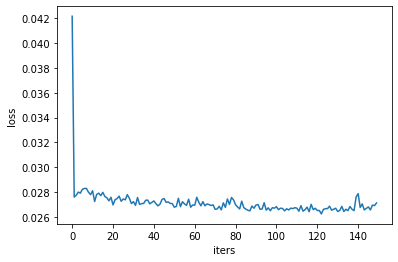

In [44]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()


In [45]:
print(eval_step(net, predicted_len=600))

Wefstohhen 
i:

vGe TrF eryhsIer n iatIsSbgs.e diI: eS sun,ee: eT
los ten h:s:oTd oidsguSe?
Ker
stddl? s
ntsFue TslsslFhy ee
OeNore El:A  laropshseeeFyn:t
s suul hml'Frdseaonn mY -
'fSehbtcus tedndnmbetaroYcsGhr!tNbsh
hetr
aone:
yhas s i
ThwRt io ressmee
d SBpl
o hNnssrhb o
 .layerq:nmieectuteecraoGasl

vtd wo   b
WydhTe h.oLGeGradeAKGg,ieoctEuSu
l Teoen o Ibd ye s AyYydr,i'unRAouees o
PsAInEHy y   yr
oee,Sesmteea RdleteosooveN mil!Ico,soro o.- iisheem,eNsso.omeuldhinp 
 nmyl,iIaery s
p I  T ssoleRNsmItn stsh
sbOdo
O  wevgi:eeode,
ibbEpyars m td
ud,deKoy ds.
traotm 
E w
sass  
egreGibe
dr
nII
,


In [17]:
# Draw the heatmap of training errors.
import seaborn as sns
def draw_heatmap1d(probability, char_list,title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(probability, annot=True, fmt='.3f', 
                     yticklabels=char_list)
    ax.collections[0].colorbar.set_label("accuracy")
    #ax.set( ylabel='%s'%(y_name))#'$\gamma$', ylabel='$C$')
    plt.title('visualization of %s' % (title))
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


In [19]:
type(string.printable)

str

In [18]:

char_list = ["I","W","Y"] #sentence from validation file. Could be a selection from training file.
import numpy as np
draw_heatmap1d(np.array(nn.Softmax(np.array(output).reshape(1,-1))),char_list,'ss')
#each cell higher prob the better ->fits ground truth

ValueError: Must pass 2-d input

<Figure size 144x288 with 0 Axes>